In [2]:
import sys
sys.path.insert(0, "../")


import utils
from dataset import CustomDataset
from torchvision import transforms
import torch.nn as nn
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA


IMAGE_DIRECTORY = "../dataset/ExpwCleaned"
LABEL_FILE = "../dataset/label_expw.csv"

LABEL_FILE_COLUMNS = ["Image name", "size", "neutral", "happiness", "surprise",
                    "sadness", "anger", "disgust", "fear", "contempt", "unknown", "NF"]



In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust to your desired image size
    transforms.ToTensor(),
])

label_data = utils.get_df(LABEL_FILE, LABEL_FILE_COLUMNS)
dataset = CustomDataset(IMAGE_DIRECTORY, label_data, transform)

print("Dataset artifacts loaded")

Dataset artifacts loaded


In [4]:
class VanillaVAE(nn.Module):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims = None,
                 device = "cuda",
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
            # hidden_dims = [24, 48, 96, 192, 384]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()
        # print("HD: ", hidden_dims)

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        # print("HIDDEN DIMS", hidden_dims[-1])

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding=1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        # print("INPUT sss: ", input.shape)
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        # print("DECORDER INPUT: ", result.shape)
        result = result.view(-1, 512, 2, 2)
        # print("result view: ", result.shape)
        result = self.decoder(result)
        # print("DECODER: ", result.shape)
        result = self.final_layer(result)
        # print("RESULT", result.shape)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.05 # Account for the minibatch samples from the dataset
        # print("RECONS: ", recons.shape)
        # print("INPUT: ", input.shape)
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [5]:
# Define hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
in_channels = 3  # Assuming RGB images, change to 1 for grayscale
latent_dim = 128
hidden_dims = [32, 64, 128, 256, 512]

# Instantiate VanillaVAE model
vae_model = VanillaVAE(in_channels, latent_dim, hidden_dims, device).to(device)

# Set the model to training mode
vae_model.train()

# Print the model architecturea
print(vae_model)

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

In [6]:
learning_rate = 3e-4
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

batch_size = 32  # Adjust as needed
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

In [42]:
num_epochs = 20
log_interval = 100

for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # print(data.size())
        # Reconstruction and KL divergence
        results = vae_model(data)
        recons_batch = results[0]
        # print(recons_batch.size())
        # print(recons_batch.size())
        mu = results[2]
        logvar = results[3]

        # Calculate the loss
        loss_dict = vae_model.loss_function(recons_batch, data, mu, logvar)
        total_loss = loss_dict['loss']

        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {total_loss.item()}")

    print(f"Epoch {epoch}, Loss: {total_loss.item()}")

print("Training finished.")

Epoch 0, Batch 0, Loss: 1.3026399612426758
Epoch 0, Batch 100, Loss: 0.06445041298866272
Epoch 0, Batch 200, Loss: 0.07268760353326797
Epoch 0, Batch 300, Loss: 0.06682731956243515
Epoch 0, Batch 400, Loss: 0.05645207688212395
Epoch 0, Batch 500, Loss: 0.06518342345952988
Epoch 0, Batch 600, Loss: 0.06354629993438721
Epoch 0, Batch 700, Loss: 0.06909848749637604
Epoch 0, Batch 800, Loss: 0.05385811999440193
Epoch 0, Batch 900, Loss: 0.0671423003077507


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/raid/biplab/phduser2/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/ut

Epoch 0, Batch 1000, Loss: 0.05229555442929268
Epoch 0, Batch 1100, Loss: 0.06549125164747238
Epoch 0, Batch 1200, Loss: 0.05995263531804085
Epoch 0, Batch 1300, Loss: 0.059842709451913834
Epoch 0, Batch 1400, Loss: 0.06142454966902733
Epoch 0, Batch 1500, Loss: 0.06435538083314896
Epoch 0, Batch 1600, Loss: 0.05366961658000946
Epoch 0, Batch 1700, Loss: 0.07373183965682983
Epoch 0, Batch 1800, Loss: 0.06362640112638474
Epoch 0, Batch 1900, Loss: 0.0637100487947464
Epoch 0, Batch 2000, Loss: 0.061845771968364716
Epoch 0, Batch 2100, Loss: 0.06318735331296921
Epoch 0, Batch 2200, Loss: 0.05696028098464012
Epoch 0, Batch 2300, Loss: 0.06868615746498108
Epoch 0, Batch 2400, Loss: 0.062321070581674576
Epoch 0, Batch 2500, Loss: 0.05999552458524704
Epoch 0, Batch 2600, Loss: 0.05943930521607399
Epoch 0, Loss: 0.07059063762426376
Epoch 1, Batch 0, Loss: 0.06276410073041916
Epoch 1, Batch 100, Loss: 0.05941011756658554
Epoch 1, Batch 200, Loss: 0.0669308453798294
Epoch 1, Batch 300, Loss: 0.0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/raid/biplab/phduser2/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/ut

Epoch 1, Batch 1000, Loss: 0.06184371933341026
Epoch 1, Batch 1100, Loss: 0.059738464653491974
Epoch 1, Batch 1200, Loss: 0.06084529682993889
Epoch 1, Batch 1300, Loss: 0.059227656573057175
Epoch 1, Batch 1400, Loss: 0.06406474113464355
Epoch 1, Batch 1500, Loss: 0.055810194462537766
Epoch 1, Batch 1600, Loss: 0.06242614611983299
Epoch 1, Batch 1700, Loss: 0.05885026976466179
Epoch 1, Batch 1800, Loss: 0.05371183529496193
Epoch 1, Batch 1900, Loss: 0.058613963425159454
Epoch 1, Batch 2000, Loss: 0.056322962045669556
Epoch 1, Batch 2100, Loss: 0.061996687203645706
Epoch 1, Batch 2200, Loss: 0.06394661217927933
Epoch 1, Batch 2300, Loss: 0.06602320820093155
Epoch 1, Batch 2400, Loss: 0.06050028279423714
Epoch 1, Batch 2500, Loss: 0.0785548985004425
Epoch 1, Batch 2600, Loss: 0.0568646639585495
Epoch 1, Loss: 0.06799484044313431
Epoch 2, Batch 0, Loss: 0.05401845648884773
Epoch 2, Batch 100, Loss: 0.05790093541145325
Epoch 2, Batch 200, Loss: 0.06616637855768204
Epoch 2, Batch 300, Loss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/raid/biplab/phduser2/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/ut

Epoch 2, Batch 1000, Loss: 0.060204293578863144
Epoch 2, Batch 1100, Loss: 0.06656026095151901
Epoch 2, Batch 1200, Loss: 0.05723065137863159
Epoch 2, Batch 1300, Loss: 0.056103676557540894
Epoch 2, Batch 1400, Loss: 0.05645197629928589
Epoch 2, Batch 1500, Loss: 0.05824535712599754
Epoch 2, Batch 1600, Loss: 0.06464245915412903
Epoch 2, Batch 1700, Loss: 0.0684538260102272
Epoch 2, Batch 1800, Loss: 0.05511869117617607
Epoch 2, Batch 1900, Loss: 0.06156785786151886
Epoch 2, Batch 2000, Loss: 0.056448280811309814
Epoch 2, Batch 2100, Loss: 0.05588705837726593
Epoch 2, Batch 2200, Loss: 0.06091388687491417
Epoch 2, Batch 2300, Loss: 0.06071963906288147
Epoch 2, Batch 2400, Loss: 0.058348122984170914
Epoch 2, Batch 2500, Loss: 0.06415320187807083
Epoch 2, Batch 2600, Loss: 0.06005498394370079
Epoch 2, Loss: 0.05070020630955696
Epoch 3, Batch 0, Loss: 0.058416321873664856
Epoch 3, Batch 100, Loss: 0.06490981578826904
Epoch 3, Batch 200, Loss: 0.05588353052735329
Epoch 3, Batch 300, Loss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/raid/biplab/phduser2/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/ut

Epoch 3, Batch 1000, Loss: 0.054571282118558884
Epoch 3, Batch 1100, Loss: 0.06086549907922745
Epoch 3, Batch 1200, Loss: 0.06356585770845413
Epoch 3, Batch 1300, Loss: 0.06430412083864212
Epoch 3, Batch 1400, Loss: 0.05268420651555061
Epoch 3, Batch 1500, Loss: 0.05315415933728218
Epoch 3, Batch 1600, Loss: 0.06096363067626953
Epoch 3, Batch 1700, Loss: 0.05064227059483528
Epoch 3, Batch 1800, Loss: 0.05559893697500229
Epoch 3, Batch 1900, Loss: 0.059740178287029266
Epoch 3, Batch 2000, Loss: 0.04775535687804222
Epoch 3, Batch 2100, Loss: 0.0632171779870987
Epoch 3, Batch 2200, Loss: 0.05906277894973755
Epoch 3, Batch 2300, Loss: 0.060828614979982376
Epoch 3, Batch 2400, Loss: 0.057085856795310974
Epoch 3, Batch 2500, Loss: 0.05789715051651001
Epoch 3, Batch 2600, Loss: 0.05444025993347168
Epoch 3, Loss: 0.061735834926366806
Epoch 4, Batch 0, Loss: 0.06477800756692886
Epoch 4, Batch 100, Loss: 0.06612352281808853
Epoch 4, Batch 200, Loss: 0.06444178521633148
Epoch 4, Batch 300, Loss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/raid/biplab/phduser2/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/ut

Epoch 4, Batch 1000, Loss: 0.0636925995349884
Epoch 4, Batch 1100, Loss: 0.06357695907354355
Epoch 4, Batch 1200, Loss: 0.06748930364847183
Epoch 4, Batch 1300, Loss: 0.05850571393966675
Epoch 4, Batch 1400, Loss: 0.05623986944556236
Epoch 4, Batch 1500, Loss: 0.06640399992465973
Epoch 4, Batch 1600, Loss: 0.0632743388414383
Epoch 4, Batch 1700, Loss: 0.05568277835845947
Epoch 4, Batch 1800, Loss: 0.05833474174141884
Epoch 4, Batch 1900, Loss: 0.05514742061495781
Epoch 4, Batch 2000, Loss: 0.06234675645828247
Epoch 4, Batch 2100, Loss: 0.058808501809835434
Epoch 4, Batch 2200, Loss: 0.05636413022875786
Epoch 4, Batch 2300, Loss: 0.06066469848155975
Epoch 4, Batch 2400, Loss: 0.06360618770122528
Epoch 4, Batch 2500, Loss: 0.06082320213317871
Epoch 4, Batch 2600, Loss: 0.060261595994234085
Epoch 4, Loss: 0.05940530449151993
Epoch 5, Batch 0, Loss: 0.053277015686035156
Epoch 5, Batch 100, Loss: 0.05698131397366524
Epoch 5, Batch 200, Loss: 0.05617714673280716
Epoch 5, Batch 300, Loss: 0.0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/raid/biplab/phduser2/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/ut

Epoch 5, Batch 1000, Loss: 0.04995106905698776
Epoch 5, Batch 1100, Loss: 0.06630232185125351
Epoch 5, Batch 1200, Loss: 0.07330851256847382
Epoch 5, Batch 1300, Loss: 0.05723543092608452
Epoch 5, Batch 1400, Loss: 0.05500498041510582
Epoch 5, Batch 1500, Loss: 0.061881713569164276
Epoch 5, Batch 1600, Loss: 0.05941316485404968
Epoch 5, Batch 1700, Loss: 0.060264091938734055
Epoch 5, Batch 1800, Loss: 0.056514132767915726
Epoch 5, Batch 1900, Loss: 0.06009947136044502
Epoch 5, Batch 2000, Loss: 0.06014446169137955
Epoch 5, Batch 2100, Loss: 0.06110428646206856
Epoch 5, Batch 2200, Loss: 0.0595184788107872
Epoch 5, Batch 2300, Loss: 0.05231447145342827
Epoch 5, Batch 2400, Loss: 0.05125180631875992
Epoch 5, Batch 2500, Loss: 0.0585249625146389
Epoch 5, Batch 2600, Loss: 0.05917251855134964
Epoch 5, Loss: 0.0608527809381485
Epoch 6, Batch 0, Loss: 0.05882227048277855
Epoch 6, Batch 100, Loss: 0.059778641909360886
Epoch 6, Batch 200, Loss: 0.060327328741550446
Epoch 6, Batch 300, Loss: 0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/raid/biplab/phduser2/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/ut

Epoch 6, Batch 1000, Loss: 0.06393245607614517
Epoch 6, Batch 1100, Loss: 0.05614560469985008
Epoch 6, Batch 1200, Loss: 0.05679889768362045
Epoch 6, Batch 1300, Loss: 0.0649605318903923
Epoch 6, Batch 1400, Loss: 0.056656427681446075
Epoch 6, Batch 1500, Loss: 0.06350505352020264
Epoch 6, Batch 1600, Loss: 0.0677114948630333
Epoch 6, Batch 1700, Loss: 0.06145923584699631


KeyboardInterrupt: 

(64, 64, 3)


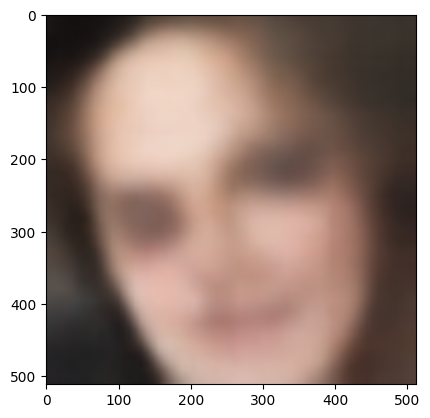

In [7]:
import cv2

vae_model.load_state_dict(torch.load("../models/weights.pt"))

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def plot_decoded_images(dataset, vae_model):
  data, _ = dataset[np.random.randint(0, len(dataset))]
  data = to_device(data, device)
  # print(data.size())
  with torch.no_grad():
    decoded_image = vae_model(data.unsqueeze(0))[0]
    # print(decoded_image.size())
  decoded_image = decoded_image[0].permute(1,2,0).detach().cpu().numpy()
  print(decoded_image.shape)
  img = cv2.resize(decoded_image, (512, 512))
  plt.imshow(img)

plot_decoded_images(dataset, vae_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64])


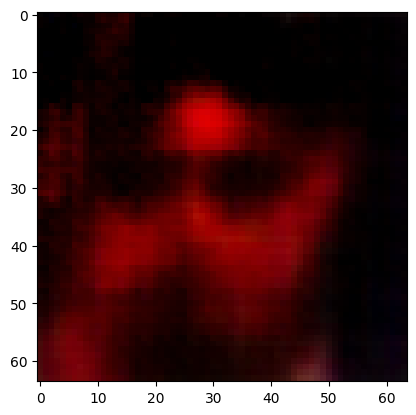

In [57]:
random = torch.randn(1, 3, 64, 64).to(device)

decoded_image = vae_model(random)[0]
print(decoded_image.size())
plt.imshow(decoded_image[0].permute(1,2,0).detach().cpu())

In [58]:
vae_model.eval()
val_loader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=2)

# Lists to store latent representations and labels
latent_representations = []
all_labels = []

# Iterate over the data in the DataLoader
with torch.no_grad():
    for data, labels in val_loader:
        # Move data and labels to the same device as the model
        # print(data.size())
        data, labels = to_device(data, device), to_device(labels, device)

        # Assuming vae_model.encode(data) returns a list of latent representations
        # Move each tensor to the CPU before appending
        mu = vae_model.encode(data)[0].detach().cpu().numpy()
        # print(mu.shape)
        
        latent_representations.extend(mu)
        
        # Convert labels to numpy array
        all_labels.append(labels.cpu().numpy())
        # break
      

84823 (128,)
(84823,) 6
(84823, 2)
Variance explained [0.02836194 0.02624176]
[0 1 2 3 4 5 6]
[ True  True  True ...  True  True False]
[False False False ... False False  True]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]


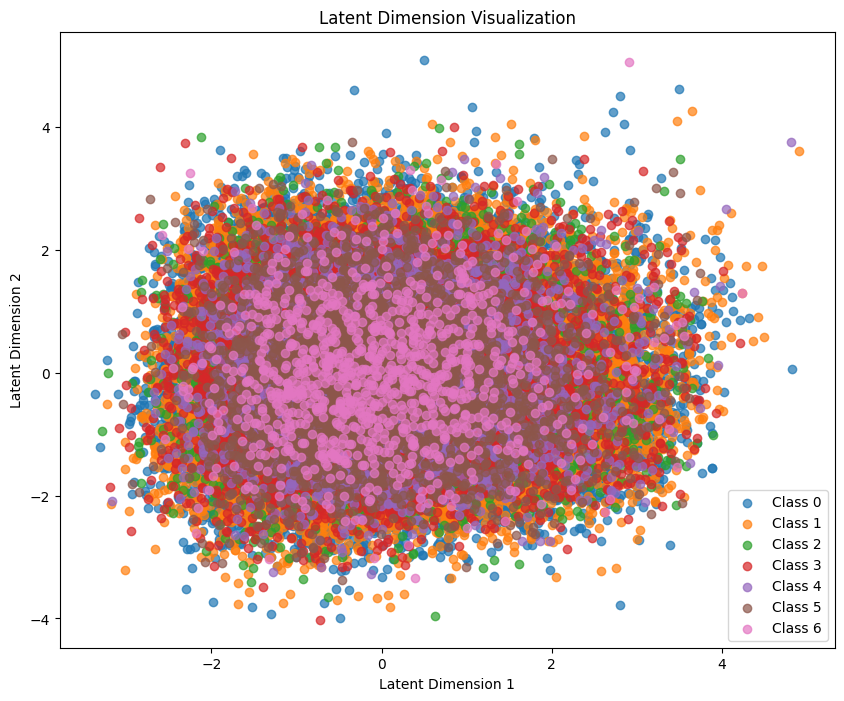

In [60]:
print(len(latent_representations), latent_representations[0].shape) 

label_num = []

for label in all_labels:
  # print(label)
  label_num.append(np.argmax(np.array(label)))

label_num = np.array(label_num)
print(label_num.shape, np.max(label_num))

# for label in all_labels:
  

rep = np.vstack(latent_representations)
pca = PCA(n_components=2)

reduced_latent_representations = pca.fit_transform(rep)
print(reduced_latent_representations.shape)

print("Variance explained",pca.explained_variance_ratio_)

unique_labels = np.arange(0, 7)
print(unique_labels)
plt.figure(figsize=(10, 8))

for label in unique_labels:
    indices = label_num == label
    print(indices)
    plt.scatter(
        reduced_latent_representations[indices, 0],
        reduced_latent_representations[indices, 1],
        label=f'Class {label}',
        alpha=0.7
    )

plt.title('Latent Dimension Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()


In [38]:
vae_model.eval()

# Lists to store latent representations and labels
latent_representations = []
all_labels = []

# Iterate over the data in the DataLoader
with torch.no_grad():
    for data, labels in train_loader:
        # Move data and labels to the same device as the model
        # print(data.size())
        data, labels = to_device(data, device), to_device(labels, device)

        # Assuming vae_model.encode(data) returns a list of latent representations
        # Move each tensor to the CPU before appending
        encodings = vae_model.encode(data)
        # print(encodings)
        latent_representations.extend([x.detach().cpu() for x in encodings])
        
        # Convert labels to numpy array
        all_labels.append(labels.cpu().numpy())
        # break

# Concatenate lists to get numpy arrays
# print(latent_representations)
latent_representations = np.concatenate(latent_representations, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Latent representations shape", latent_representations[0].shape, latent_representations[1].shape)
print("Labels shape", all_labels.shape)

# Randomly select a subset of data points
# reduced_latent_representations = PCA(n_components=2).fit_transform(latent_representations)

# # Create a scatter plot with color-coded points based on class labels
# unique_labels = np.unique(all_labels)
# plt.figure(figsize=(10, 8))

# for label in unique_labels:
#     indices = subset_labels == label
#     plt.scatter(
#         reduced_latent_representations[indices, 0],
#         reduced_latent_representations[indices, 1],
#         label=f'Class {label}',
#         alpha=0.7
#     )

# plt.title('Latent Dimension Visualization')
# plt.xlabel('Latent Dimension 1')
# plt.ylabel('Latent Dimension 2')
# plt.legend()
# plt.show()

# Example usage:
# Assuming vae_model and train_loader are defined

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/raid/biplab/phduser2/miniconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc09dddb940>
Traceback (most recent call last):
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/raid/biplab/phduser2/.local/lib/python3.8/site-packages/torch/ut

[tensor([[ 5.7296e-02,  7.7953e-03, -1.6956e-02,  ..., -2.1856e-01,
          1.5732e-01,  4.4384e-02],
        [ 6.1638e-02, -1.6988e-01,  6.5244e-02,  ..., -1.3102e-01,
          8.2426e-02,  5.8422e-02],
        [-3.3772e-02, -4.0958e-03,  4.4954e-02,  ...,  3.3944e-02,
         -2.9069e-02,  6.3605e-03],
        ...,
        [ 1.5650e-01, -1.4914e-01, -1.0033e-04,  ..., -5.1882e-02,
          2.7602e-02, -3.0996e-02],
        [ 5.7347e-02, -5.0660e-02,  6.8472e-03,  ..., -1.0768e-02,
          3.0307e-02, -7.7012e-03],
        [-4.1499e-02,  2.8750e-02,  4.6418e-02,  ...,  1.0035e-01,
         -1.2775e-01,  1.1913e-02]]), tensor([[-0.0113, -0.0016, -0.0129,  ..., -0.0030, -0.0171, -0.0304],
        [ 0.0133, -0.0285,  0.0052,  ..., -0.0091, -0.0318, -0.0263],
        [-0.0017, -0.0142,  0.0221,  ...,  0.0040, -0.0460, -0.0036],
        ...,
        [ 0.0099, -0.0030, -0.0067,  ..., -0.0166, -0.0249, -0.0005],
        [-0.0028, -0.0139, -0.0080,  ...,  0.0006, -0.0340, -0.0215],
   